In [13]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

Load Training Data ~ 300 images

In [43]:
#Required size for input channels is 299 * 299 
transform = transforms.Compose([transforms.Resize(299),
                                transforms.CenterCrop(299),
                                transforms.ToTensor()])
train_dataset = datasets.ImageFolder(
        'dataset/train_images',
        transform=transform)
test_dataset = datasets.ImageFolder(
        'dataset/test_images',
        transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

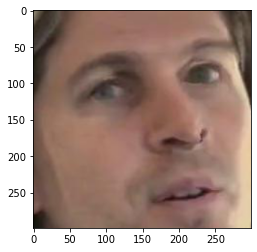

In [15]:
#Testing face load with first image
import matplotlib.pyplot as plt
images, labels = next(iter(train_dataloader))
plt.imshow(images[0].permute(1, 2, 0))

Defining custom class for xception model

In [23]:
class Xception_Net(nn.Module):
    def __init__(
        self,
        num_classes: int = 100,
    ) -> None:
        super(Xception_Net, self).__init__()
        
        #Entry flow layer 1
        self.entry_flow_1 = nn.Sequential(
            #input channels for images is 3
            nn.Conv2d(3, 32, kernel_size = (3, 3), stride = (2, 2), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(32, 64, kernel_size = (3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )
        
        #Entry flow layer 2 - Separable convolution layer
        self.entry_flow_2_sep_conv = nn.Sequential(
            #performing depthwise and pointwise convolutions
            nn.Conv2d(64, 128, kernel_size = (3, 3), padding=1),
            nn.Conv2d(128, 128, kernel_size = (1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(128, 128, kernel_size = (3, 3), padding=1),
            nn.Conv2d(128, 128, kernel_size = (1, 1)),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size = (3, 3), stride = (2, 2), padding=1)
            
        )
        
        #Entry flow layer 2 - Residual Convoltuional layer
        self.entry_flow_2_residual = nn.Sequential(
            #with kernel size 1, padding is set to default 0
            nn.Conv2d(64, 128, kernel_size = (1, 1), stride = (2, 2))    
        )
        
        #Entry flow layer 3 - Separable convolution layer
        self.entry_flow_3_sep_conv = nn.Sequential(
            #performing depthwise and pointwise convolutions
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 256, kernel_size = (3, 3), padding=1),
            nn.Conv2d(256, 256, kernel_size = (1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(256, 256, kernel_size = (3, 3), padding=1),
            nn.Conv2d(256, 256, kernel_size = (1, 1)),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size = (3, 3), stride = (2, 2), padding=1)
            
        )
        
        #Entry flow layer 3 - Residual Convoltuional layer
        self.entry_flow_3_residual = nn.Sequential(
            #with kernel size 1, padding is set to default 0
            nn.Conv2d(128, 256, kernel_size = (1, 1), stride = (2, 2)),
            nn.BatchNorm2d(256)
        )
        
        #Entry flow layer 4 - Separable convolution layer
        self.entry_flow_4_sep_conv = nn.Sequential(
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 728, kernel_size = (3, 3), padding=1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding=1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            nn.MaxPool2d(kernel_size = (3, 3), stride = (2, 2), padding=1)
            
        )
        
        #Entry flow layer 4 - Residual Convoltuional layer
        self.entry_flow_4_residual = nn.Sequential(
            #with kernel size 1, padding is set to default 0
            nn.Conv2d(256, 728, kernel_size = (1, 1), stride = (2, 2)),
            nn.BatchNorm2d(728)
        )
        
        ######## Middle Flow ##########
        # 3 separable convolution layers
        self.middle_flow = nn.Sequential(
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728)
        )
        
        ######## Exit Flow #########
        #Exit flow layer 1 - Separable convolution layer
        self.exit_flow_1_sep_conv = nn.Sequential(
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 1024, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(1024, 1024, kernel_size = (1, 1)),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(kernel_size = (3, 3), stride = (2, 2), padding=1)
        )
        
        #Exit flow layer 1 - Residual Convoltuional layer
        self.exit_flow_1_residual = nn.Sequential(
            #with kernel size 1, padding is set to default 0
            nn.Conv2d(728, 1024, kernel_size = (1, 1), stride = (2, 2)),
            nn.BatchNorm2d(1024)
        )
        
        #Exit flow layer 2 - Separable convolution layer
        self.exit_flow_2_sep_conv = nn.Sequential(
            nn.Conv2d(1024, 1536, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(1536, 1536, kernel_size = (1, 1)),
            nn.BatchNorm2d(1536),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(1536, 2048, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(2048, 2048, kernel_size = (1, 1)),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace = True),
            
            #global average pooling
            nn.AdaptiveAvgPool2d(None),
            
            #final linear layer
            nn.Linear(2048, num_classes)
        )
        

        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #entry flow
        x = self.entry_flow_1(x)
        x = self.entry_flow_2_sep_conv(x) + self.entry_flow_2_residual(x)
        x = self.entry_flow_3_sep_conv(x) + self.entry_flow_3_residual(x)
        x = self.entry_flow_4_sep_conv(x) + self.entry_flow_4_residual(x)

        #middle flow is repeated 8 times
        for i in range(8):
            x = self.middle_flow(x)
        
        #exit flow
        x = self.exit_flow_1_sep_conv(x) + self.exit_flow_1_residual(x)
        x = self.exit_flow_2_sep_conv(x)
        
        return x

In [46]:
class Xception_Net(nn.Module):
    def __init__(
        self,
        num_classes: int = 2,
    ) -> None:
        super(Xception_Net, self).__init__()
        
        #Entry flow layer 1
        self.entry_flow_1 = nn.Sequential(
            #input channels for images is 3
            nn.Conv2d(3, 32, kernel_size = (3, 3), stride = (2, 2), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(32, 64, kernel_size = (3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )
        
        #Entry flow layer 2 - Separable convolution layer
        self.entry_flow_2_sep_conv = nn.Sequential(
            #performing depthwise and pointwise convolutions
            nn.Conv2d(64, 128, kernel_size = (3, 3), padding=1),
            nn.Conv2d(128, 128, kernel_size = (1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(128, 128, kernel_size = (3, 3), padding=1),
            nn.Conv2d(128, 128, kernel_size = (1, 1)),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size = (3, 3), stride = (2, 2), padding=1)
            
        )
        
        #Entry flow layer 2 - Residual Convoltuional layer
        self.entry_flow_2_residual = nn.Sequential(
            #with kernel size 1, padding is set to default 0
            nn.Conv2d(64, 128, kernel_size = (1, 1), stride = (2, 2))    
        )
        
        #Entry flow layer 3 - Separable convolution layer
        self.entry_flow_3_sep_conv = nn.Sequential(
            #performing depthwise and pointwise convolutions
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 256, kernel_size = (3, 3), padding=1),
            nn.Conv2d(256, 256, kernel_size = (1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(256, 256, kernel_size = (3, 3), padding=1),
            nn.Conv2d(256, 256, kernel_size = (1, 1)),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size = (3, 3), stride = (2, 2), padding=1)
            
        )
        
        #Entry flow layer 3 - Residual Convoltuional layer
        self.entry_flow_3_residual = nn.Sequential(
            #with kernel size 1, padding is set to default 0
            nn.Conv2d(128, 256, kernel_size = (1, 1), stride = (2, 2)),
            nn.BatchNorm2d(256)
        )
        
        #Entry flow layer 4 - Separable convolution layer
        self.entry_flow_4_sep_conv = nn.Sequential(
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 728, kernel_size = (3, 3), padding=1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding=1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            nn.MaxPool2d(kernel_size = (3, 3), stride = (2, 2), padding=1)
            
        )
        
        #Entry flow layer 4 - Residual Convoltuional layer
        self.entry_flow_4_residual = nn.Sequential(
            #with kernel size 1, padding is set to default 0
            nn.Conv2d(256, 728, kernel_size = (1, 1), stride = (2, 2)),
            nn.BatchNorm2d(728)
        )
        
        ######## Middle Flow ##########
        # 3 separable convolution layers
        self.middle_flow = nn.Sequential(
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728)
        )
        
        ######## Exit Flow #########
        #Exit flow layer 1 - Separable convolution layer
        self.exit_flow_1_sep_conv = nn.Sequential(
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 1024, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(1024, 1024, kernel_size = (1, 1)),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(kernel_size = (3, 3), stride = (2, 2), padding=1)
        )
        
        #Exit flow layer 1 - Residual Convoltuional layer
        self.exit_flow_1_residual = nn.Sequential(
            #with kernel size 1, padding is set to default 0
            nn.Conv2d(728, 1024, kernel_size = (1, 1), stride = (2, 2)),
            nn.BatchNorm2d(1024)
        )
        
        #Exit flow layer 2 - Separable convolution layer
        self.exit_flow_2_sep_conv = nn.Sequential(
            nn.Conv2d(1024, 1536, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(1536, 1536, kernel_size = (1, 1)),
            nn.BatchNorm2d(1536),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(1536, 2048, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(2048, 2048, kernel_size = (1, 1)),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace = True),
            
            #global average pooling
            #nn.AdaptiveAvgPool2d((1,1)),
            
            #final linear layer
            #nn.Linear(2048, num_classes)
        )
        
        self.linear = nn.Linear(2048, num_classes)
        

        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #entry flow
        x = self.entry_flow_1(x)
        x = self.entry_flow_2_sep_conv(x) + self.entry_flow_2_residual(x)
        x = self.entry_flow_3_sep_conv(x) + self.entry_flow_3_residual(x)
        x = self.entry_flow_4_sep_conv(x) + self.entry_flow_4_residual(x)

        #middle flow is repeated 8 times
        for i in range(8):
            x = self.middle_flow(x)
        
        #exit flow
        x = self.exit_flow_1_sep_conv(x) + self.exit_flow_1_residual(x)
        x = self.exit_flow_2_sep_conv(x)
        
        """
        Move global average pooling and final linear layer here.
        """
        avg = nn.functional.adaptive_avg_pool2d(x,(1,1))
        flat = avg.view(avg.size(0),-1)
        
        x = self.linear(flat)
        
        return x
        

In [47]:
device = torch.device("cuda:0") # if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [48]:
net = Xception_Net().to(device)

In [49]:
net

Xception_Net(
  (entry_flow_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (entry_flow_2_sep_conv): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(3, 3), stride=(

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3)

In [51]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [52]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
loss_record = []

for t in range(10):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader,net,loss_fn,optimizer)
    test(test_dataloader,net)
print('Done!')

Epoch 1
-------------------------------
loss: 0.713087  [    0/  298]
loss: 0.016243  [  100/  298]
loss: 0.007719  [  200/  298]
Test Error: 
 Accuracy: 50.0%, Avg loss: 50.125822 

Epoch 2
-------------------------------
loss: 23.234640  [    0/  298]


In [ ]:
loss_record = []
for epoch in range(10):
    

Text(0.5, 1.0, 'real')

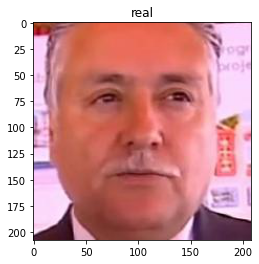

In [37]:
from PIL import Image
import matplotlib.pyplot as plt
classes = ['fake','real']

transform = transforms.Compose([transforms.Resize(299),
                                transforms.CenterCrop(299),
                                transforms.ToTensor()])

img = Image.open('dataset/test_images/real/real00772.jpg')
imgt = transform(img)

pre = net(imgt.unsqueeze(0).cuda())
pre = pre.data.argmax().item()

plt.imshow(img)
plt.title(classes[pre])